
<br>
<h1 style="text-align:center; font-size:46px; font-weight:800; margin-bottom:0;">
Cybersecurity - IoT Intrusion Dataset
</h1>
<p style="text-align:center; font-size:22px; color:gray; margin-top:5px;">
Conv1D Neural Network for Time Series Analysis
</p>
<br>
<p style="text-align:center;">
  <img src="img/ai.jpg" style="width:85%; max-width:900px; border-radius:10px; box-shadow:0px 0px 12px rgba(0,0,0,0.25);">
</p>
<br>
<p style="text-align:center; font-size:16px; color:gray;">
Environment & Tools: Python • PyTorch • NumPy • Pandas • Scikit-Learn • Matplotlib
</p>
<br>


The dataset used in this analysis is publicly available from an open-source repository on Kaggle.  
You can access it here: [insert URL].

We will be using a **1D Convolutional Neural Network (Conv1D CNN)** to perform **time-series analysis** on the dataset.
Conv1D is particularly suited for sequential data, as it can capture temporal patterns across the input sequence of features.


<hr>
<h2 style="text-align:center; font-weight:700;">📚 Libraries Used in This Project</h2>
<p style="text-align:center; color:gray; font-size:15px;">Core tools used for data processing, modeling, and visualization.</p>
<br>
<table style="margin-left:auto; margin-right:auto; text-align:center;">
  <tr>
    <td><img src="img/numpy.jpg" width="60"><br><strong>NumPy</strong><br><span style="color:gray; font-size:13px;">Numerical<br>Computing</span></td>
    <td><img src="img/pandas.png" width="60"><br><strong>Pandas</strong><br><span style="color:gray; font-size:13px;">Data<br>Manipulation</span></td>
    <td><img src="img/pytorch.jpg" width="100"><br><strong>PyTorch</strong><br><span style="color:gray; font-size:13px;">Deep<br>Learning</span></td>
  </tr>
  <tr>
    <td><img src="img/scikitlearn.png" width="60"><br><strong>Scikit-Learn</strong><br><span style="color:gray; font-size:13px;">ML Tools<br>& Metrics</span></td>
    <td><img src="img/matplotlib.jpg" width="90"><br><strong>Matplotlib</strong><br><span style="color:gray; font-size:13px;">Visualization</span></td>
  </tr>
</table>
<br>
<hr>


In [19]:
"""
Created on Thu Oct 23 18:45:00 2025

@author: ybenjaminpcondori
"""

# System & OS utilities
import os

# Data manipulation
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Scikit-Learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt


Declaring Classes and Functions

In [ ]:
########################################################
# CNN BASELINE CONV1D (MINIMAL)
########################################################
class Convolutional_Neural_Network(nn.Module):
    def __init__(self, num_classes, num_features):
        super().__init__()

        # Model Architecture
        self.conv = nn.Conv1d(
            in_channels=1,
            out_channels=8,    
            kernel_size=3,
            padding=1
        )

        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()

        # Compute flatten size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, num_features)
            x = self.pool(self.relu(self.conv(dummy)))
            self.flatten_dim = x.view(1, -1).shape[1]

        # Direct to output (no hidden FC)
        self.out = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)      # (B, 1, F)
        x = self.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.out(x)


############################################
# Binary counting helper
############################################
class DataPreprocessing:
    @staticmethod
    def count_binary(series):
        counts = series.value_counts()
        return pd.Series({'0': counts.get(0, 0), '1': counts.get(1, 0)})


Data Preprocessing

In [21]:
df = pd.read_csv("IoT_Intrusion.csv")

In [22]:
columns = ['HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']
for col in columns:
    _ = df[col].value_counts()

In [23]:
counts_df = df[columns].apply(DataPreprocessing.count_binary)
print(counts_df)
print("Unique label count:", df['label'].nunique())
print("Unique labels:", df['label'].unique())
print("Label counts:\n", df['label'].value_counts())

encoder = LabelEncoder()
df['label_encoded'] = encoder.fit_transform(df['label'])

     HTTP   HTTPS      DNS   Telnet     SMTP      SSH      IRC     TCP  \
0  997735  990633  1048433  1048575  1048575  1048512  1048575  446278   
1   50840   57942      142        0        0       63        0  602297   

      UDP     DHCP      ARP    ICMP      IPv      LLC  
0  826349  1048573  1048505  877307      119      119  
1  222226        2       70  171268  1048456  1048456  
Unique label count: 34
Unique labels: ['DDoS-RSTFINFlood' 'DoS-TCP_Flood' 'DDoS-ICMP_Flood' 'DoS-UDP_Flood'
 'DoS-SYN_Flood' 'Mirai-greeth_flood' 'DDoS-SynonymousIP_Flood'
 'Mirai-udpplain' 'DDoS-SYN_Flood' 'DDoS-PSHACK_Flood' 'DDoS-TCP_Flood'
 'DDoS-UDP_Flood' 'BenignTraffic' 'MITM-ArpSpoofing'
 'DDoS-ACK_Fragmentation' 'Mirai-greip_flood' 'DoS-HTTP_Flood'
 'DDoS-ICMP_Fragmentation' 'Recon-PortScan' 'DNS_Spoofing'
 'DDoS-UDP_Fragmentation' 'Recon-OSScan' 'XSS' 'DDoS-HTTP_Flood'
 'Recon-HostDiscovery' 'CommandInjection' 'VulnerabilityScan'
 'DDoS-SlowLoris' 'Backdoor_Malware' 'BrowserHijacking'
 'Dicti

In [24]:
############################################
# CLASS ↔ ATTACK LABEL MAPPING (FOR REPORTING)
############################################

id_to_attack = dict(enumerate(encoder.classes_))
attack_to_id = {label: idx for idx, label in id_to_attack.items()}

print("\nClass ID → Attack Type mapping:\n")
for k, v in id_to_attack.items():
    print(f"Class {k}: {v}")

mapping_df = pd.DataFrame({
    "Class ID": list(id_to_attack.keys()),
    "Attack Type": list(id_to_attack.values())
})

mapping_df.to_csv("class_label_mapping.csv", index=False)
print("\n[✓] Saved class_label_mapping.csv")


Class ID → Attack Type mapping:

Class 0: Backdoor_Malware
Class 1: BenignTraffic
Class 2: BrowserHijacking
Class 3: CommandInjection
Class 4: DDoS-ACK_Fragmentation
Class 5: DDoS-HTTP_Flood
Class 6: DDoS-ICMP_Flood
Class 7: DDoS-ICMP_Fragmentation
Class 8: DDoS-PSHACK_Flood
Class 9: DDoS-RSTFINFlood
Class 10: DDoS-SYN_Flood
Class 11: DDoS-SlowLoris
Class 12: DDoS-SynonymousIP_Flood
Class 13: DDoS-TCP_Flood
Class 14: DDoS-UDP_Flood
Class 15: DDoS-UDP_Fragmentation
Class 16: DNS_Spoofing
Class 17: DictionaryBruteForce
Class 18: DoS-HTTP_Flood
Class 19: DoS-SYN_Flood
Class 20: DoS-TCP_Flood
Class 21: DoS-UDP_Flood
Class 22: MITM-ArpSpoofing
Class 23: Mirai-greeth_flood
Class 24: Mirai-greip_flood
Class 25: Mirai-udpplain
Class 26: Recon-HostDiscovery
Class 27: Recon-OSScan
Class 28: Recon-PingSweep
Class 29: Recon-PortScan
Class 30: SqlInjection
Class 31: Uploading_Attack
Class 32: VulnerabilityScan
Class 33: XSS

[✓] Saved class_label_mapping.csv


Data Cleaning

In [25]:
df.drop_duplicates(inplace=True)
df.columns = df.columns.str.strip().str.lower()

In [26]:
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

Identify Features and Target Columns

In [27]:
target = 'label_encoded'
features = [c for c in df.columns if c not in ['label', 'label_encoded']]

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [28]:
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df[target].values, dtype=torch.long)
print(X.shape, y.shape)

torch.Size([983019, 46]) torch.Size([983019])


Train / Test Split

In [29]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X.numpy(), y.numpy(), test_size=0.2, random_state=42, stratify=y.numpy())

X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
y_test = torch.tensor(y_test_np, dtype=torch.long)

batch_size = 512
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Model Definition

In [30]:
num_classes = len(df[target].unique())
num_features = X_train.shape[1]

model = Convolutional_Neural_Network(num_classes, num_features).to(device)
print(model)

Convolutional_Neural_Network(
  (conv): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (out): Linear(in_features=184, out_features=34, bias=True)
)


Training

In [31]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50

In [32]:
loss_across_epochs = []
val_accuracy_across_epochs = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = loss_function(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    loss_across_epochs.append(avg_loss)

    # Validation
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for bx, by in test_loader:
            bx, by = bx.to(device), by.to(device)
            preds = torch.argmax(model(bx), dim=1)
            correct += (preds == by).sum().item()
            total += by.size(0)

    val_acc = correct / total
    val_accuracy_across_epochs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f}")

Epoch 1/50 - Loss: 0.6230 - Val Acc: 0.7900
Epoch 2/50 - Loss: 0.4594 - Val Acc: 0.7978
Epoch 3/50 - Loss: 0.4461 - Val Acc: 0.8010
Epoch 4/50 - Loss: 0.4369 - Val Acc: 0.8027
Epoch 5/50 - Loss: 0.4291 - Val Acc: 0.8017
Epoch 6/50 - Loss: 0.4229 - Val Acc: 0.8131
Epoch 7/50 - Loss: 0.4176 - Val Acc: 0.8109
Epoch 8/50 - Loss: 0.4128 - Val Acc: 0.8119
Epoch 9/50 - Loss: 0.4078 - Val Acc: 0.8165
Epoch 10/50 - Loss: 0.4039 - Val Acc: 0.8144
Epoch 11/50 - Loss: 0.3994 - Val Acc: 0.8260
Epoch 12/50 - Loss: 0.3961 - Val Acc: 0.8311
Epoch 13/50 - Loss: 0.3921 - Val Acc: 0.8481
Epoch 14/50 - Loss: 0.3883 - Val Acc: 0.8412
Epoch 15/50 - Loss: 0.3851 - Val Acc: 0.8432
Epoch 16/50 - Loss: 0.3809 - Val Acc: 0.8451
Epoch 17/50 - Loss: 0.3783 - Val Acc: 0.8431
Epoch 18/50 - Loss: 0.3745 - Val Acc: 0.8624
Epoch 19/50 - Loss: 0.3714 - Val Acc: 0.8450
Epoch 20/50 - Loss: 0.3686 - Val Acc: 0.8440
Epoch 21/50 - Loss: 0.3660 - Val Acc: 0.8680
Epoch 22/50 - Loss: 0.3634 - Val Acc: 0.8720
Epoch 23/50 - Loss:

Evaluation

In [33]:
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for bx, by in test_loader:
        bx = bx.to(device)
        preds = torch.argmax(model(bx), dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(by.numpy())

print(classification_report(all_true, all_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.76      0.95      0.84      4895
           2       0.33      0.07      0.12        28
           3       0.15      0.10      0.12        21
           4       0.99      0.97      0.98      1286
           5       0.92      0.47      0.62       125
           6       1.00      1.00      1.00     27458
           7       0.96      0.98      0.97      2043
           8       1.00      1.00      1.00     16783
           9       1.00      1.00      1.00     15688
          10       0.78      0.92      0.85     17238
          11       0.53      0.74      0.61        99
          12       0.95      0.96      0.96     15799
          13       0.97      0.95      0.96     18406
          14       0.87      0.88      0.87     24241
          15       0.99      0.98      0.99      1286
          16       0.43      0.32      0.36       807
          17       0.80    

c:\Users\ybenj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ybenj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ybenj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Evaluation

In [34]:
# ------------------------------------------------------------
# Model Evaluation
# ------------------------------------------------------------

model.eval()

# Containers for predictions, probabilities, and ground truth
all_preds = []
all_probs = []
all_true = []

# Disable gradient tracking for evaluation
with torch.no_grad():
    for bx, by in test_loader:
        bx = bx.to(device)

        # Forward pass
        logits = model(bx)

        # Predicted class labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        # Class probabilities (softmax output)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_probs.extend(probs)
        all_true.extend(by.numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_true = np.array(all_true)

# ------------------------------------------------------------
# Quantitative Evaluation Metrics
# ------------------------------------------------------------

print("=" * 80)
print("MODEL EVALUATION METRICS")
print("=" * 80)

# Classification report (precision, recall, F1-score per class)
print("\nClassification Report:")
print(classification_report(all_true, all_preds))

# ------------------------------------------------------------
# F1 Scores
# ------------------------------------------------------------
from sklearn.metrics import f1_score

macro_f1 = f1_score(all_true, all_preds, average='macro', zero_division=0)
weighted_f1 = f1_score(all_true, all_preds, average='weighted', zero_division=0)

print("\nF1 Scores:")
print(f"  Macro F1 Score:     {macro_f1:.4f}")
print(f"  Weighted F1 Score:  {weighted_f1:.4f}")

# ------------------------------------------------------------
# Recall Metrics
# ------------------------------------------------------------
from sklearn.metrics import recall_score

macro_recall = recall_score(all_true, all_preds, average='macro', zero_division=0)
weighted_recall = recall_score(all_true, all_preds, average='weighted', zero_division=0)
per_class_recall = recall_score(all_true, all_preds, average=None, zero_division=0)

print("\nRecall Scores:")
print(f"  Macro Recall:     {macro_recall:.4f}")
print(f"  Weighted Recall:  {weighted_recall:.4f}")
print("  Per-class Recall:")
for i, recall in enumerate(per_class_recall):
    print(f"    Class {i}: {recall:.4f}")

# ------------------------------------------------------------
# Confusion Matrix
# ------------------------------------------------------------
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_true, all_preds)

print("\nConfusion Matrix:")
print(cm)

# ------------------------------------------------------------
# ROC-AUC Metrics
# ------------------------------------------------------------
from sklearn.metrics import roc_auc_score, accuracy_score

try:
    if num_classes == 2:
        # Binary classification
        macro_auc = roc_auc_score(all_true, all_probs[:, 1])
        print("\nROC-AUC:")
        print(f"  Binary AUC: {macro_auc:.4f}")
    else:
        # Multi-class classification (One-vs-Rest)
        macro_auc = roc_auc_score(
            all_true, all_probs, multi_class='ovr', average='macro'
        )
        weighted_auc = roc_auc_score(
            all_true, all_probs, multi_class='ovr', average='weighted'
        )

        print("\nROC-AUC:")
        print(f"  Macro AUC (OvR):     {macro_auc:.4f}")
        print(f"  Weighted AUC (OvR):  {weighted_auc:.4f}")

except Exception as e:
    print("\nROC-AUC could not be computed:")
    print(str(e))

# ------------------------------------------------------------
# Overall Accuracy
# ------------------------------------------------------------
accuracy = accuracy_score(all_true, all_preds)
print(f"\nOverall Accuracy: {accuracy:.4f}")
print("=" * 80)

MODEL EVALUATION METRICS

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.76      0.95      0.84      4895
           2       0.33      0.07      0.12        28
           3       0.15      0.10      0.12        21
           4       0.99      0.97      0.98      1286
           5       0.92      0.47      0.62       125
           6       1.00      1.00      1.00     27458
           7       0.96      0.98      0.97      2043
           8       1.00      1.00      1.00     16783
           9       1.00      1.00      1.00     15688
          10       0.78      0.92      0.85     17238
          11       0.53      0.74      0.61        99
          12       0.95      0.96      0.96     15799
          13       0.97      0.95      0.96     18406
          14       0.87      0.88      0.87     24241
          15       0.99      0.98      0.99      1286
          16       0.43      0.3

c:\Users\ybenj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ybenj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ybenj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Recall Scores:
  Macro Recall:     0.6108
  Weighted Recall:  0.9145
  Per-class Recall:
    Class 0: 0.0000
    Class 1: 0.9510
    Class 2: 0.0714
    Class 3: 0.0952
    Class 4: 0.9736
    Class 5: 0.4720
    Class 6: 0.9989
    Class 7: 0.9814
    Class 8: 0.9991
    Class 9: 0.9989
    Class 10: 0.9247
    Class 11: 0.7374
    Class 12: 0.9618
    Class 13: 0.9515
    Class 14: 0.8763
    Class 15: 0.9759
    Class 16: 0.3160
    Class 17: 0.1846
    Class 18: 0.8631
    Class 19: 0.5389
    Class 20: 0.9494
    Class 21: 0.7860
    Class 22: 0.5598
    Class 23: 0.9617
    Class 24: 0.9525
    Class 25: 0.9945
    Class 26: 0.6672
    Class 27: 0.1955
    Class 28: 0.0000
    Class 29: 0.1019
    Class 30: 0.0000
    Class 31: 0.0000
    Class 32: 0.7284
    Class 33: 0.0000

Confusion Matrix:
[[   0    3    0 ...    1    0    0]
 [   0 4655    1 ...    1    0    6]
 [   0   19    2 ...    0    0    0]
 ...
 [   0    3    0 ...    0    0    0]
 [   0    0    0 ...    0  118    

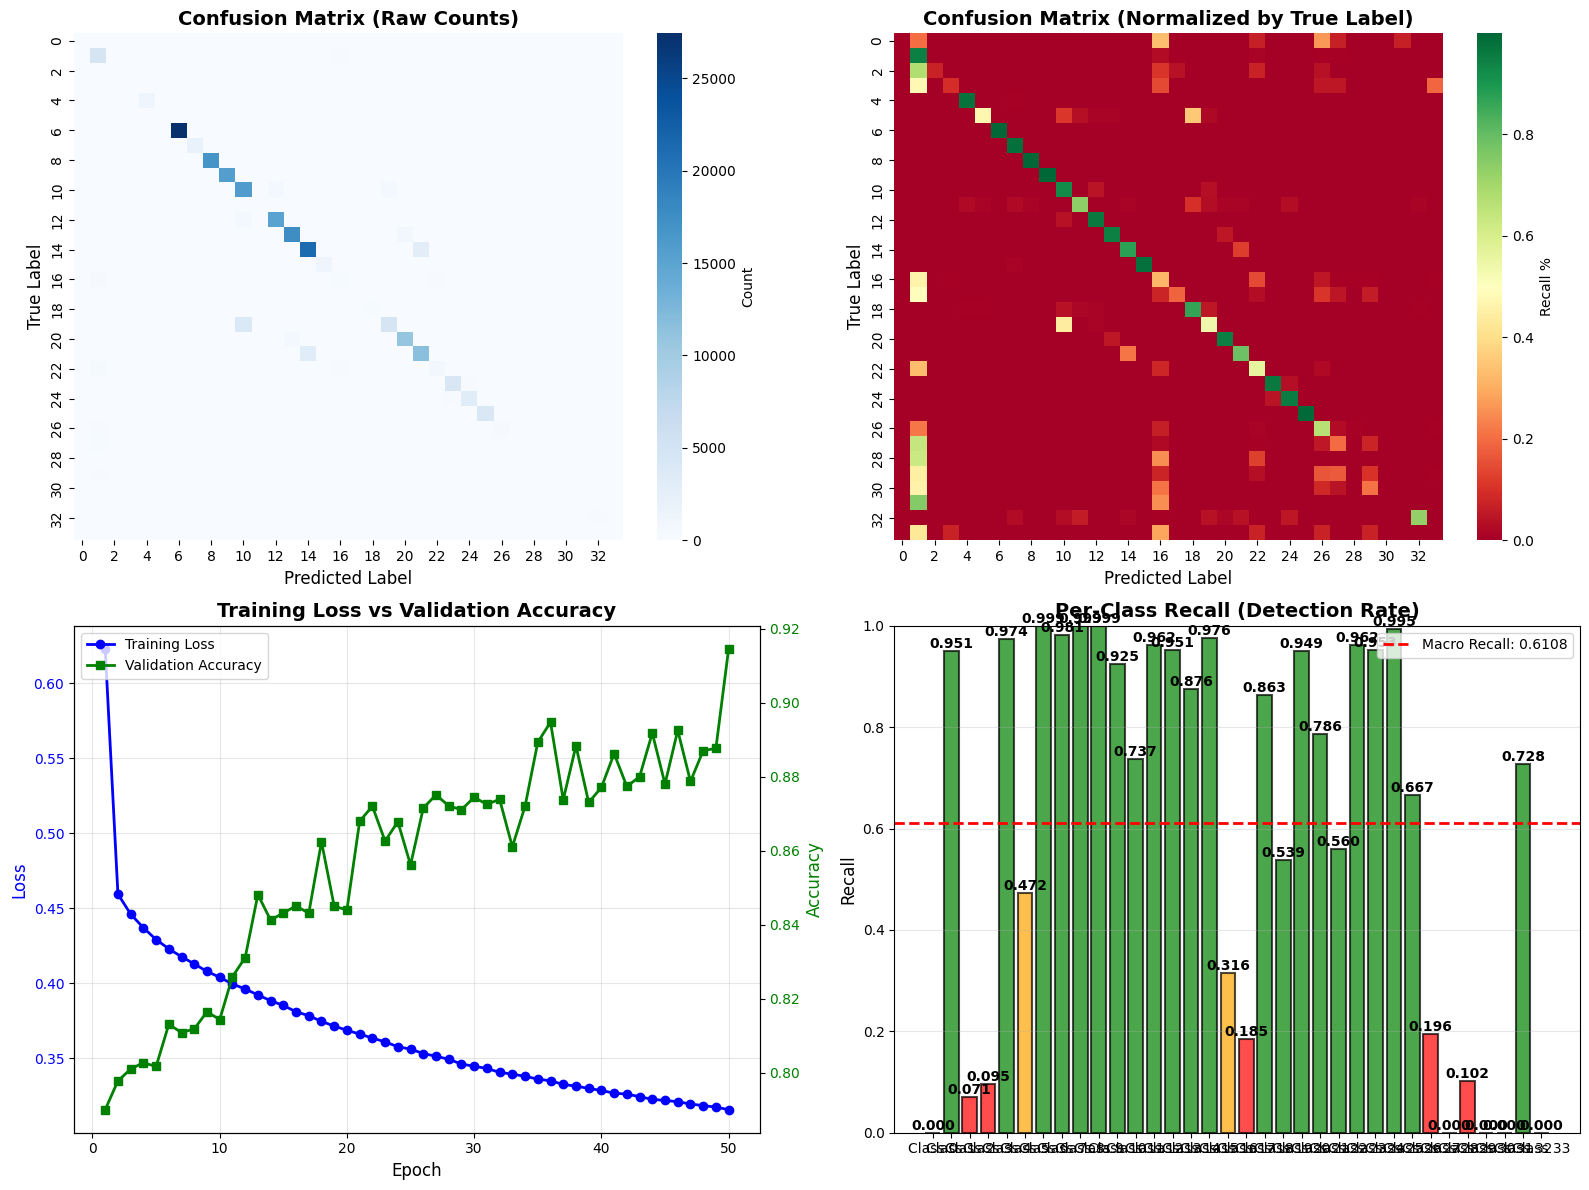


 Visualizations saved as 'model_evaluation_metrics.png'


In [35]:

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# 2. Normalized Confusion Matrix
ax2 = axes[0, 1]
sns.heatmap(cm_normalized, annot=False, fmt='.2%', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Recall %'})
ax2.set_title('Confusion Matrix (Normalized by True Label)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

# 3. Training Loss and Validation Accuracy
ax3 = axes[1, 0]
epochs_range = range(1, len(loss_across_epochs) + 1)
ax3_twin = ax3.twinx()
line1 = ax3.plot(epochs_range, loss_across_epochs, 'b-o', label='Training Loss', linewidth=2, markersize=6)
line2 = ax3_twin.plot(epochs_range, val_accuracy_across_epochs, 'g-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12, color='b')
ax3_twin.set_ylabel('Accuracy', fontsize=12, color='g')
ax3.tick_params(axis='y', labelcolor='b')
ax3_twin.tick_params(axis='y', labelcolor='g')
ax3.grid(True, alpha=0.3)
ax3.set_title('Training Loss vs Validation Accuracy', fontsize=14, fontweight='bold')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left', fontsize=10)

# 4. Per-Class Recall Bar Chart
ax4 = axes[1, 1]
class_names = [f'Class {i}' for i in range(len(per_class_recall))]
colors = ['green' if r > 0.5 else 'orange' if r > 0.3 else 'red' for r in per_class_recall]
bars = ax4.bar(class_names, per_class_recall, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.axhline(y=macro_recall, color='r', linestyle='--', linewidth=2, label=f'Macro Recall: {macro_recall:.4f}')
ax4.set_ylabel('Recall', fontsize=12)
ax4.set_title('Per-Class Recall (Detection Rate)', fontsize=14, fontweight='bold')
ax4.set_ylim([0, 1])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, recall in zip(bars, per_class_recall):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{recall:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualizations saved as 'model_evaluation_metrics.png'")


Data Analysis / Visualization

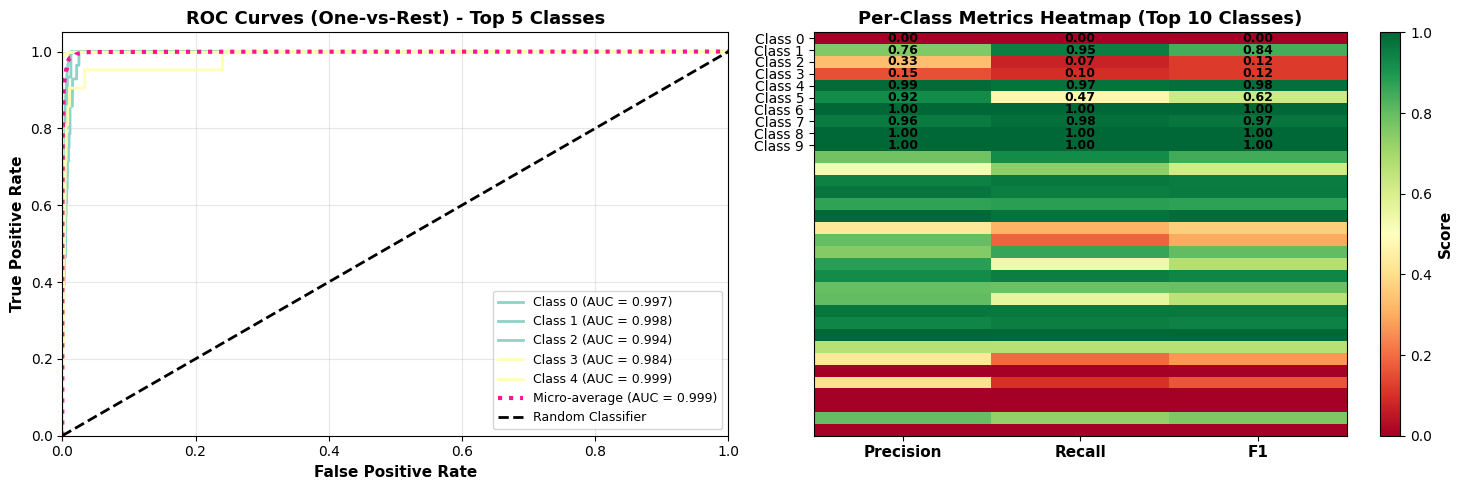

 ROC and metrics heatmap visualization saved as 'roc_and_metrics_heatmap.png'


In [36]:
#
# ROC-AUC Curves (One-vs-Rest for multi-class)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. ROC Curve (One-vs-Rest)
ax1 = axes[0]
if num_classes > 2:
    # Multi-class: use label binarization
    all_true_bin = label_binarize(all_true, classes=range(num_classes))
    
    colors = plt.cm.Set3(np.linspace(0, 1, num_classes))
    auc_scores = []
    
    for i in range(min(num_classes, 5)):  # Limit to 5 classes for clarity
        fpr, tpr, _ = roc_curve(all_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        ax1.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')
    
    # Micro-average
    fpr, tpr, _ = roc_curve(all_true_bin.ravel(), all_probs.ravel())
    roc_auc_micro = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='deeppink', lw=3, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_title('ROC Curves (One-vs-Rest) - Top 5 Classes', fontsize=13, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=9)
    ax1.grid(True, alpha=0.3)
else:
    # Binary classification
    fpr, tpr, _ = roc_curve(all_true, all_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_title('ROC Curve', fontsize=13, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=10)
    ax1.grid(True, alpha=0.3)

# 2. Per-Class Metrics Heatmap
ax2 = axes[1]
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(all_true, all_preds, 
                                                                   average=None, zero_division=0)

metrics_data = np.array([precision, recall, f1]).T
im = ax2.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=11, fontweight='bold')
ax2.set_yticks(range(min(len(precision), 10)))
ax2.set_yticklabels([f'Class {i}' for i in range(min(len(precision), 10))], fontsize=10)
ax2.set_title('Per-Class Metrics Heatmap (Top 10 Classes)', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(min(len(precision), 10)):
    for j in range(3):
        text = ax2.text(j, i, f'{metrics_data[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Score', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('roc_and_metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC and metrics heatmap visualization saved as 'roc_and_metrics_heatmap.png'")
